<a href="https://colab.research.google.com/github/yasminessa/classify-if-a-device-is-faulty-based-on-its-output-data/blob/main/final_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import random
import warnings

import matplotlib.pyplot as plt
import missingno as mn
import numpy as np
import pandas as pd
import seaborn as sns
from lightgbm import LGBMClassifier
from sklearn.ensemble import HistGradientBoostingClassifier, RandomForestClassifier,
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

plt.style.use('ggplot')


random_state= 42
np.random.seed(random_state)
random.seed(random_state)
warnings.filterwarnings('ignore')

In [2]:
train = pd.read_csv('https://raw.githubusercontent.com/yasminessa/classify-if-a-device-is-faulty-based-on-its-output-data/main/train.csv')
test = pd.read_csv('https://raw.githubusercontent.com/yasminessa/classify-if-a-device-is-faulty-based-on-its-output-data/main/test.csv')
#ss = pd.read_csv('SampleSubmission.csv')
ss = test.ID

In [3]:
train.head()

,ID,Datetime,Sensor1_PM2.5,Sensor2_PM2.5,Temperature,Relative_Humidity,Offset_fault
0,ID_QF0ZTQJ2SF5Q,2021-11-03 04:06:31,52.58,49.52,17.4,96.0,0
1,ID_4GTK689CNX5S,2021-11-08 18:43:23,35.25,33.40,25.0,75.0,0
2,ID_DL7VVKW9U7XQ,2021-11-07 09:50:33,19.18,23.50,24.9,75.0,0
3,ID_6XQOMBXM2DG3,2022-01-01 18:55:15,19.40,15.48,24.9,70.0,0
4,ID_UQZW9ISJY9QE,2021-11-05 22:23:48,38.30,34.77,20.9,89.0,0


In [40]:
train.tail()

,Sensor1_PM2.5,Sensor2_PM2.5,Temperature,Relative_Humidity,Offset_fault,Datetime_day,Datetime_month,Datetime_year,Datetime_hour,Datetime_minute,Datetime_dayofweek,is_morning,is_afternoon,is_evening,is_night
297172,36.40,37.77,28.6,62.0,0,19,11,2021,12,32,4,False,True,False,False
297173,50.12,40.63,21.6,86.0,1,22,11,2021,1,22,0,False,False,False,True
297174,53.68,45.23,20.2,94.0,1,5,11,2021,1,27,4,False,False,False,True
297175,96.45,114.67,20.6,93.0,0,23,11,2021,22,9,1,False,False,True,False
297176,44.27,36.77,17.3,95.0,1,23,11,2021,6,33,1,True,False,False,False


In [4]:
test.head()

,ID,Datetime,Sensor1_PM2.5,Sensor2_PM2.5,Temperature,Relative_Humidity
0,ID_STL3V9B2OU12,2022-01-28 08:49:41,90.75,114.78,22.2,56.0
1,ID_U2EKAY4SGA94,2022-02-16 21:30:17,56.03,52.18,NaN,NaN
2,ID_UJFLEWQR0U4N,2022-01-24 17:57:18,387.35,346.73,28.1,63.0
3,ID_S2C2GPGA4R5I,2022-01-31 07:07:09,63.17,83.85,21.6,82.0
4,ID_5V2C2ZL221H8,2022-01-31 00:37:05,69.23,53.07,22.7,80.0


In [5]:
# ss.head()

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 297177 entries, 0 to 297176
Data columns (total 7 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   ID                 297177 non-null  object 
 1   Datetime           297177 non-null  object 
 2   Sensor1_PM2.5      293563 non-null  float64
 3   Sensor2_PM2.5      293563 non-null  float64
 4   Temperature        293628 non-null  float64
 5   Relative_Humidity  293628 non-null  float64
 6   Offset_fault       297177 non-null  int64  
dtypes: float64(4), int64(1), object(2)
memory usage: 15.9+ MB


In [7]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 127361 entries, 0 to 127360
Data columns (total 6 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   ID                 127361 non-null  object 
 1   Datetime           127361 non-null  object 
 2   Sensor1_PM2.5      127361 non-null  float64
 3   Sensor2_PM2.5      127361 non-null  float64
 4   Temperature        39271 non-null   float64
 5   Relative_Humidity  39271 non-null   float64
dtypes: float64(4), object(2)
memory usage: 5.8+ MB


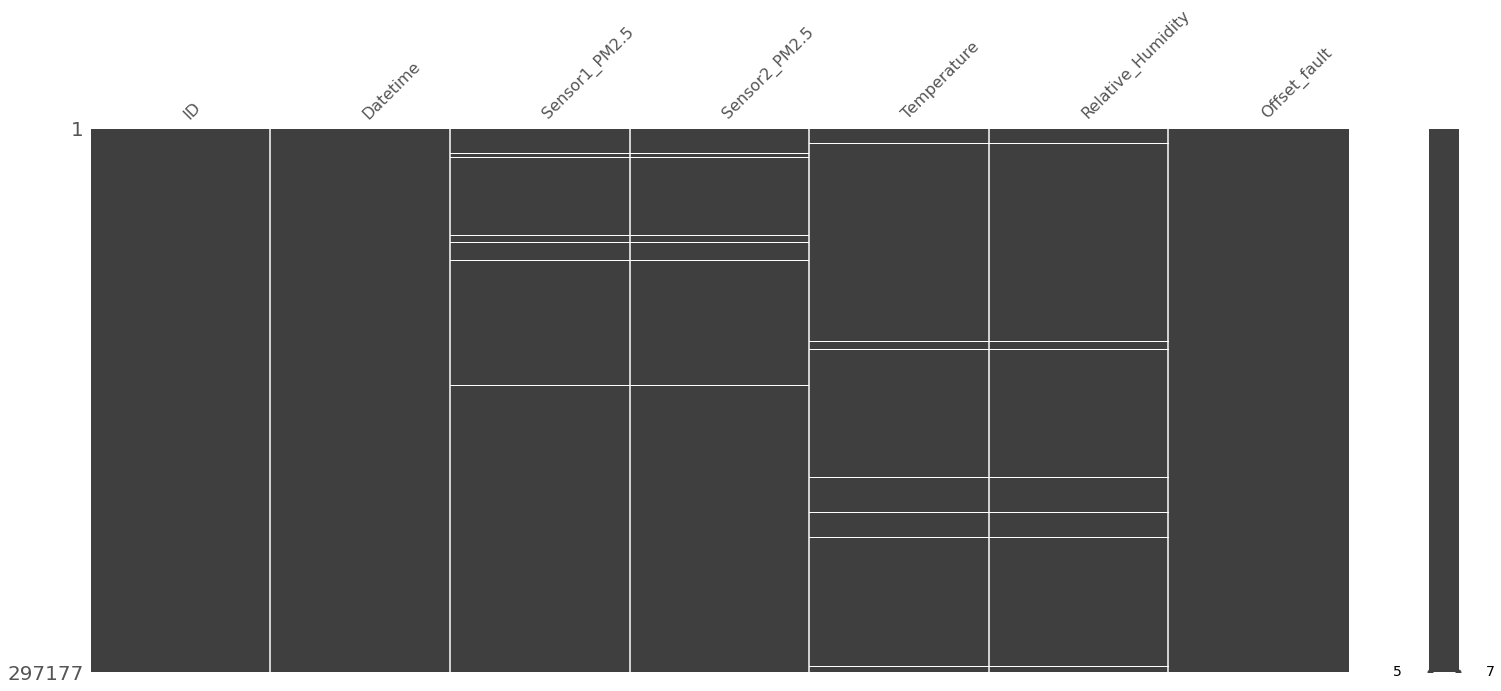

In [8]:
mn.matrix(train)

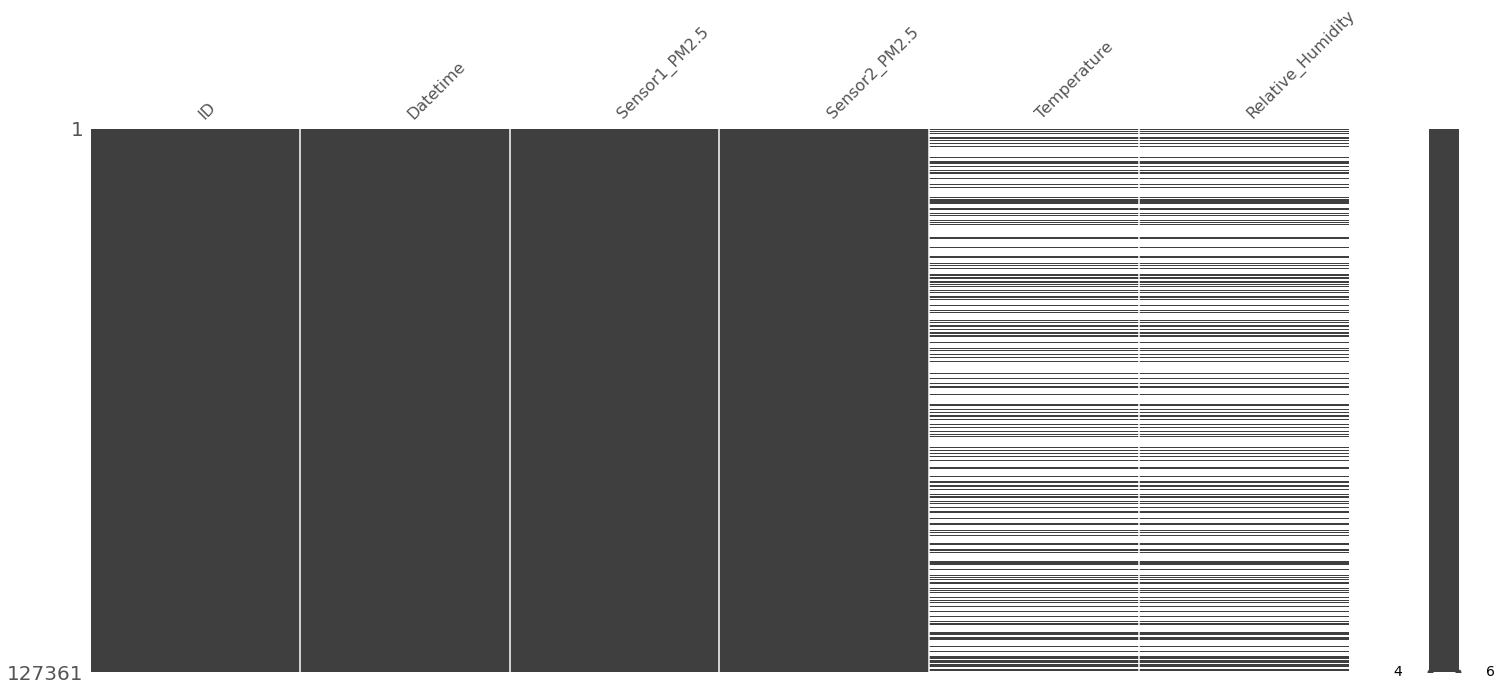

In [9]:
mn.matrix(test)

In [10]:
train = train.drop('ID',axis=1)
test = test.drop('ID',axis=1)

In [11]:
train.loc[:, 'Sensor1_PM2.5':'Offset_fault'].describe().T.style.bar(subset=['mean'], color='#206ff2')\
                            .background_gradient(subset=['std'], cmap='Reds')\
                            .background_gradient(subset=['50%'], cmap='coolwarm')

,count,mean,std,min,25%,50%,75%,max
Sensor1_PM2.5,293563.000000,40.751195,28.526182,-9.450000,22.430000,36.470000,49.420000,997.960000
Sensor2_PM2.5,293563.000000,38.183018,28.647761,-9.700000,19.520000,33.720000,47.570000,997.260000
Temperature,293628.000000,23.316554,3.836971,16.700000,20.400000,21.900000,26.300000,34.900000
Relative_Humidity,293628.000000,78.653623,14.772725,27.000000,68.000000,84.000000,91.000000,99.000000
Offset_fault,297177.000000,0.371072,0.483092,0.000000,0.000000,0.000000,1.000000,1.000000


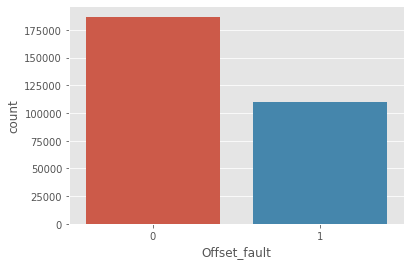

In [12]:
### Now let's visualize 
sns.countplot(train.Offset_fault)

In [13]:
# Extract day, month year and hour from the Datetime column
# day
def converte_dates(df):
    
    df['Datetime'] = pd.to_datetime(df['Datetime'])
    
    #
    df['Datetime_day'] = df.Datetime.dt.day

    # month
    df['Datetime_month'] = df.Datetime.dt.month

    # year
    df['Datetime_year'] = df.Datetime.dt.year

    # hour
    df['Datetime_hour'] = df.Datetime.dt.hour
    
    # minute
    df['Datetime_minute'] = df.Datetime.dt.minute
    
    # day of week
    df['Datetime_dayofweek'] = df.Datetime.dt.weekday
    
    
    return df


train = converte_dates(train)
test = converte_dates(test)

In [14]:
def more_features(df):
    df['is_morning'] = (6 <= df['Datetime_hour']) & (df['Datetime_hour'] < 12)#.median()
    df['is_afternoon'] = (12 <= df['Datetime_hour']) & (df['Datetime_hour'] < 18)#.median()
    df['is_evening'] = (18 <= df['Datetime_hour']) & (df['Datetime_hour'] <= 23)#.median()
    df['is_night'] = (0 <= df['Datetime_hour']) & (df['Datetime_hour'] < 6)#.median()
    return df


train = more_features(train)
test = more_features(test)

In [15]:
corr = train.corr()
corr.style.background_gradient()

,Sensor1_PM2.5,Sensor2_PM2.5,Temperature,Relative_Humidity,Offset_fault,Datetime_day,Datetime_month,Datetime_year,Datetime_hour,Datetime_minute,Datetime_dayofweek,is_morning,is_afternoon,is_evening,is_night
Sensor1_PM2.5,1.000000,0.959253,-0.390342,0.345020,-0.176257,-0.065845,-0.165492,0.161995,-0.058490,-0.000501,0.005246,0.084063,-0.345226,0.159475,0.099684
Sensor2_PM2.5,0.959253,1.000000,-0.363295,0.318470,-0.309739,-0.060088,-0.172149,0.172634,-0.054364,-0.000481,0.000965,0.080507,-0.321080,0.147091,0.091623
Temperature,-0.390342,-0.363295,1.000000,-0.933608,0.005218,-0.012197,0.033259,-0.027746,0.374180,0.000575,0.001721,-0.159391,0.692063,-0.075966,-0.446118
Relative_Humidity,0.345020,0.318470,-0.933608,1.000000,-0.005508,0.054963,0.090350,-0.093323,-0.389953,-0.000132,0.009902,0.202005,-0.660733,0.022660,0.425752
Offset_fault,-0.176257,-0.309739,0.005218,-0.005508,1.000000,0.003973,0.006119,-0.004846,0.004706,0.000194,-0.000755,-0.002761,0.003058,0.003029,-0.003269
Datetime_day,-0.065845,-0.060088,-0.012197,0.054963,0.003973,1.000000,0.269636,-0.313015,-0.003369,0.000952,0.038032,-0.001047,-0.003515,-0.000148,0.004652
Datetime_month,-0.165492,-0.172149,0.033259,0.090350,0.006119,0.269636,1.000000,-0.986940,0.006486,0.000115,0.016727,-0.004147,-0.002766,0.009331,-0.002366
Datetime_year,0.161995,0.172634,-0.027746,-0.093323,-0.004846,-0.313015,-0.986940,1.000000,-0.008027,-0.000183,-0.024027,0.004720,0.002631,-0.010660,0.003243
Datetime_hour,-0.058490,-0.054364,0.374180,-0.389953,0.004706,-0.003369,0.006486,-0.008027,1.000000,0.000474,0.003859,-0.242939,0.256325,0.750688,-0.752726
Datetime_minute,-0.000501,-0.000481,0.000575,-0.000132,0.000194,0.000952,0.000115,-0.000183,0.000474,1.000000,0.000479,-0.002075,0.000808,0.000538,0.000728


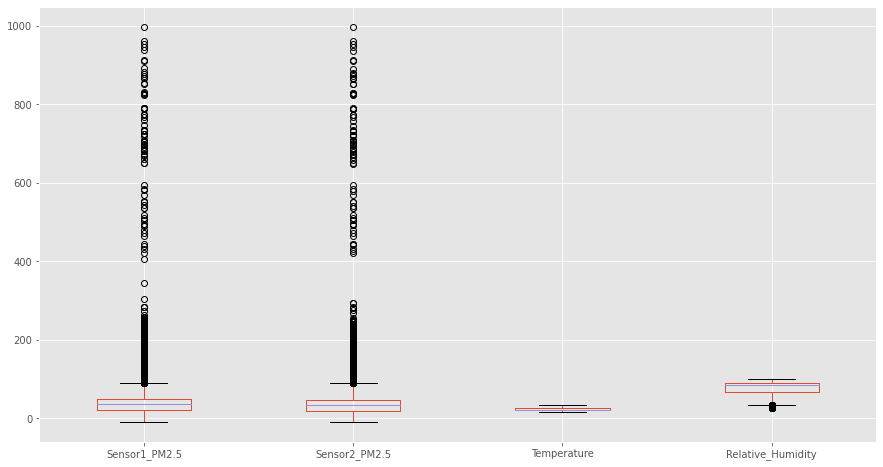

In [16]:
plt.rcParams['figure.figsize']=(15,8)
train.boxplot(column=['Sensor1_PM2.5',
 'Sensor2_PM2.5',
 'Temperature',
 'Relative_Humidity'])
plt.show()

From the  above plot we can see that our features **Sensor1_PM2.5 and Sensor2_MP2.5** is show a huge outliers so for the first time I try dropping them then we might loss so many data I decide to keep it as it and I will scale the features later on.

In [17]:
train.shape,test.shape

((297177, 16), (127361, 15))

In [18]:
train = train.drop('Datetime',axis=1)
test = test.drop('Datetime',axis=1)

In [19]:
# feature_names = train.drop(['Offset_fault','Datetime_month','Datetime_year'], axis=1).columns
# for i in range(len(feature_names)-1):
#     figure = plt.figure()
#     ax = sns.boxplot(x='Offset_fault', y=feature_names[i], data=train)

In [20]:
train.shape

(297177, 15)

In [21]:
X = train.drop('Offset_fault',axis=1)
y = train['Offset_fault']



Here I am capturing NaN per row and making new feature.<br>
I am doing this because sometime missing carry signal so we only give it to the model.


In [22]:
def feature_engineering(df):
    df['NaN_row'] = df.isna().sum(axis=1)
    df['std'] = df.std(axis=1)
    return df

X = feature_engineering(X)
test = feature_engineering(test)

# added code

In [23]:
def feature_engineering(df):
    #df['AverageTemperature'] = df['Temperature'].mean(axis=0)
    df['AverageTemperature'] = df.groupby('Relative_Humidity')['Temperature'].transform('mean')
    df['AverageHumidity'] = df.groupby('Temperature')['Relative_Humidity'].transform('mean')
    # df['Relative_Humidity'] = df['Relative_Humidity'].mean(axis=0)
    df['Total_sensor'] = df['Sensor1_PM2.5'] + df['Sensor2_PM2.5']
    
    return df

X = feature_engineering(X)
test = feature_engineering(test)

X.head()

,Sensor1_PM2.5,Sensor2_PM2.5,Temperature,Relative_Humidity,Datetime_day,Datetime_month,Datetime_year,Datetime_hour,Datetime_minute,Datetime_dayofweek,is_morning,is_afternoon,is_evening,is_night,NaN_row,std,AverageTemperature,AverageHumidity,Total_sensor
0,52.58,49.52,17.4,96.0,3,11,2021,4,6,2,False,False,False,True,0,518.087244,19.225618,96.000000,102.10
1,35.25,33.40,25.0,75.0,8,11,2021,18,43,0,False,False,True,False,0,517.665411,23.488154,73.424399,68.65
2,19.18,23.50,24.9,75.0,7,11,2021,9,50,6,True,False,False,False,0,518.074715,23.488154,71.555641,42.68
3,19.40,15.48,24.9,70.0,1,1,2022,18,55,5,False,False,True,False,0,518.627532,25.374640,71.555641,34.88
4,38.30,34.77,20.9,89.0,5,11,2021,22,23,4,False,False,True,False,0,517.765326,20.804341,89.117179,73.07


In [24]:
X.shape

(297177, 19)

### Pipeline for data transformation 

In [25]:
pipeline = Pipeline([
    ('impute', SimpleImputer(strategy='mean')),
    ('scale', StandardScaler())
])

X = pd.DataFrame(columns=X.columns, data=pipeline.fit_transform(X))
test = pd.DataFrame(columns=test.columns, data=pipeline.transform(test))

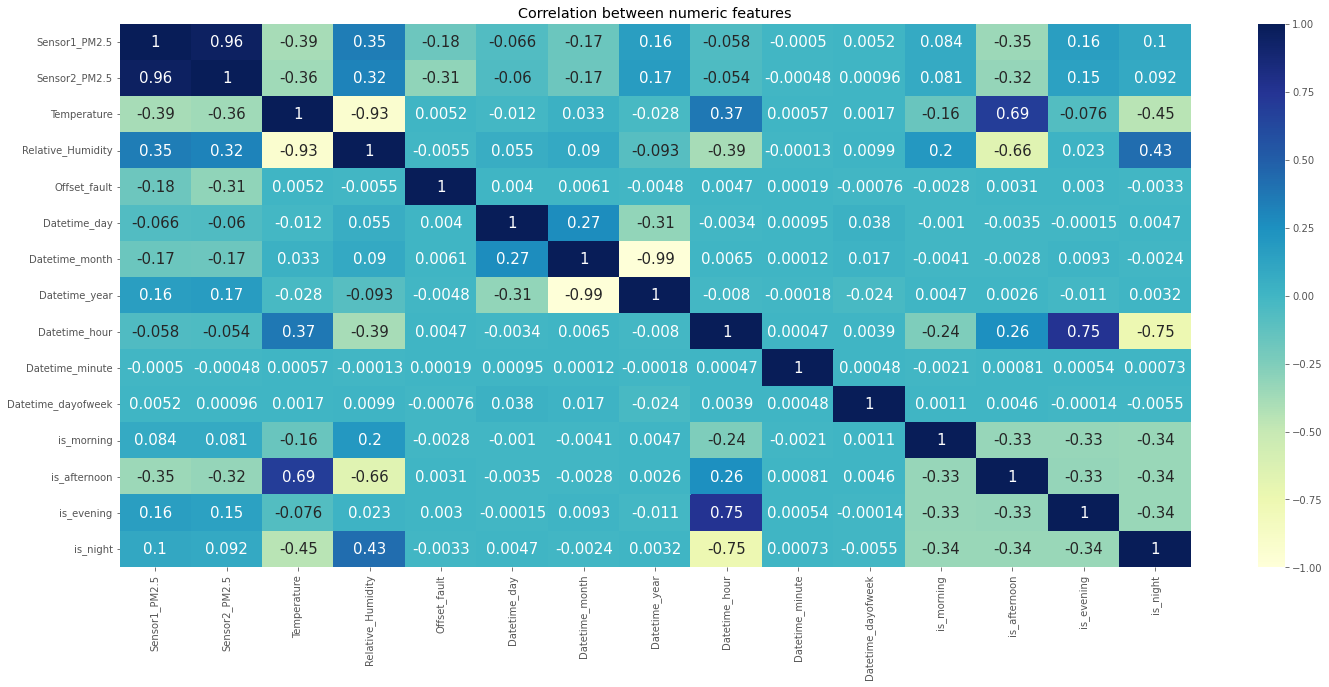

In [26]:
plt.figure(figsize=(24,10))
sns.heatmap(train.corr(), cmap='YlGnBu', vmax=1.0, vmin=-1.0, annot = True, annot_kws={"size": 15})
plt.title('Correlation between numeric features')
plt.show()

 Our Sensor1 and Sensor2 is showing highly correlation we are supposed to drop one but I did combine them to find the total sensor so for now I am going to keep them.

In [27]:
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state= 42, test_size=0.02)

In [28]:
# # lgb_params = {
#     "objective" : "binary",
#     "metric" : "accuracy",
#     "boosting": 'gbdt',
#     # #"max_depth" : -1,
#     # "num_leaves" : 13,
#     # "learning_rate" : 0.01,
#     # "bagging_freq": 5,
#     # "bagging_fraction" : 0.4,
#     # "feature_fraction" : 0.05,
#     # "min_data_in_leaf": 80,
#     # "min_sum_heassian_in_leaf": 10,
#     # "tree_learner": "serial",
#     # "boost_from_average": "false",
#     #"lambda_l1" : 5,
#     #"lambda_l2" : 5,
#     "bagging_seed" : random_state,
#     "verbosity" : 1,
#     "seed": random_state
# }



params = {'n_estimators': 1040, 'max_depth': 3, 'reg_lambda': 0.16661201237472856, 
          'colsample_bytree': 0.9064439932687255, 'num_leaves': 450, 
          'min_child_samples': 21, 'subsample': 0.5564713817638391, 'random_state':0}
lgb= LGBMClassifier(**params)




# lgb = LGBMClassifier(
#     objective='binary',learning_rate=0.1, class_weight='balanced',
#     boosting_type ='gbdt',
#     bagging_seed = random_state,
#     importance_type='gain',
#     metric = "accuracy",
# )
                    
lgb.fit(X_train,y_train)

LGBMClassifier(colsample_bytree=0.9064439932687255, max_depth=3,
               min_child_samples=21, n_estimators=1040, num_leaves=450,
               random_state=0, reg_lambda=0.16661201237472856,
               subsample=0.5564713817638391)

In [29]:
y_pred = lgb.predict(X_test)

In [30]:
accuracy_score(y_test,y_pred)

0.9470053835800808

In [31]:
print(f"Training Accuracy: {lgb.score(X_train, y_train):0.3f}")
print(f"Test Accuracy: {lgb.score(X_test, y_test):0.3f}")

Training Accuracy: 0.949
Test Accuracy: 0.947


In [32]:
pred_lgb = lgb.predict(test)
sub = pd.DataFrame({'ID':ss,'Offset_fault':pred_lgb})
sub.to_csv('lgb.csv',index=False)

In [33]:
lgb = LGBMClassifier()
lgb.fit(X_train.values, y_train)
y_pred = lgb.predict(X_test)
print(f'Accuracy score on the X_test is: {accuracy_score(y_test, y_pred)}')

Accuracy score on the X_test is: 0.9454912516823688


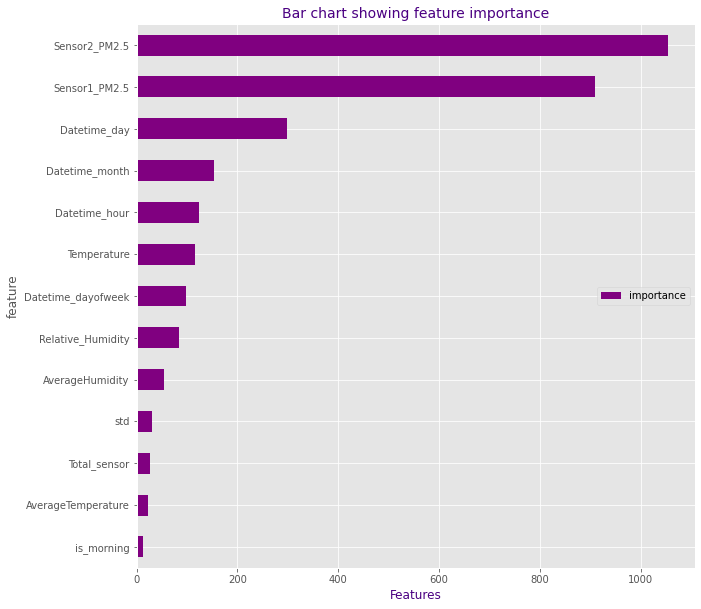

In [34]:
# Feature importance
impo_df = pd.DataFrame({'feature': X.columns, 'importance': lgb.feature_importances_}).set_index('feature').sort_values(by = 'importance', ascending = False)
impo_df = impo_df[:13].sort_values(by = 'importance', ascending = True)
impo_df.plot(kind = 'barh', figsize = (10, 10), color = 'purple')
plt.legend(loc = 'center right')
plt.title('Bar chart showing feature importance', color = 'indigo', fontsize = 14)
plt.xlabel('Features', fontsize = 12, color = 'indigo')
plt.show()

In [35]:
X.columns.to_list()

['Sensor1_PM2.5',
 'Sensor2_PM2.5',
 'Temperature',
 'Relative_Humidity',
 'Datetime_day',
 'Datetime_month',
 'Datetime_year',
 'Datetime_hour',
 'Datetime_minute',
 'Datetime_dayofweek',
 'is_morning',
 'is_afternoon',
 'is_evening',
 'is_night',
 'NaN_row',
 'std',
 'AverageTemperature',
 'AverageHumidity',
 'Total_sensor']

In [36]:
to_drop = ['NaN_row','Datetime_year']
test_df = test.drop(to_drop,axis=1)

Now let's try to use stratify so make sure data label is well distributed

In [37]:
X_train,X_test,y_train,y_test = train_test_split(X.drop(to_drop,axis=1), y, random_state=42, test_size=0.05,stratify=y)

# LightGBM algorithm

In [38]:
lgb = LGBMClassifier(objective='binary',learning_rate=0.1,class_weight='balanced')
lgb.fit(X_train.values, y_train)
y_pred = lgb.predict(X_test)
print(f'Accuracy score on the X_test is: {accuracy_score(y_test, y_pred)}')

Accuracy score on the X_test is: 0.9489871458375395


In [39]:
pred_lgb = lgb.predict(test_df)
sub = pd.DataFrame({'ID':ss,'Offset_fault':pred_lgb})
sub.to_csv('lgb_model.csv',index=False)

## Random Forest Classifier

In [41]:
rf = RandomForestClassifier()
rf.fit(X_train,y_train)

preds = rf.predict(X_test)


In [43]:
print(f"Training Accuracy: {rf.score(X_train, y_train):0.3f}")
print(f"Test Accuracy: {rf.score(X_test, y_test):0.3f}")

Training Accuracy: 1.000
Test Accuracy: 0.977


## Histogram gradient Boosting


In [44]:
hgb = HistGradientBoostingClassifier()
hgb.fit(X_train, y_train)

preds = hgb.predict(X_test)

print(f"Training Accuracy: {hgb.score(X_train, y_train):0.3f}")
print(f"Test Accuracy: {hgb.score(X_test, y_test):0.3f}")

Training Accuracy: 0.948
Test Accuracy: 0.951
